### EDA

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
import seaborn as sns

Loading dataset we'll be training with:

In [2]:
train = pd.read_csv('data/train.csv.zip')

In [3]:
train.shape #4167 rows & 74 columns

(4167, 74)

As it's quite large, let's tweak pd options to dive into our dataset comfortably. This way we can display columns/rows desired with no kind of restriction.

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

 ## Looking @ our target

In [5]:
train['price'].describe()

count    4167.000000
mean      168.676986
std       180.658555
min         0.000000
25%        98.000000
50%       138.000000
75%       200.000000
max      6477.000000
Name: price, dtype: float64

In [6]:
train['price'].max(),train['price'].min() # FREE acomodations!! yay!! - probably scrape error

(6477.0, 0.0)

In [7]:
train[train['price'] == 0] #4 free acomodations

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
190,190,https://www.airbnb.com/rooms/42431450,20211205213126,2021-12-05,Melrose Hotel,NaN,NaN,https://a0.muscache.com/pictures/92796479-d704...,311321908,https://www.airbnb.com/users/show/311321908,Melrose Hotel,2019-11-22,NL,NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/5e591...,https://a0.muscache.com/im/pictures/user/5e591...,NaN,9,9,"['email', 'phone', 'jumio', 'offline_governmen...",t,t,NaN,Centrum-West,NaN,52.369640,4.880040,Room in hotel,Hotel room,4,NaN,NaN,NaN,NaN,"[""Air conditioning"", ""Bed sheets and pillows"",...",0.0,1,365,1.0,1.0,365.0,365.0,1.0,365.0,NaN,t,0,0,0,0,2021-12-05,6,5,0,2020-11-16,2021-10-22,4.17,4.17,4.33,4.67,4.33,4.83,3.83,NaN,f,4,0,3,0,0.47
437,437,https://www.airbnb.com/rooms/42431273,20211205213126,2021-12-06,Hotel Abba,NaN,NaN,https://a0.muscache.com/pictures/8b8ce867-afeb...,309119467,https://www.airbnb.com/users/show/309119467,Hotel Abba,2019-11-13,NL,NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/5b13d...,https://a0.muscache.com/im/pictures/user/5b13d...,Oud-West,6,6,"['email', 'phone']",t,t,NaN,De Baarsjes - Oud-West,NaN,52.362790,4.874580,Room in hotel,Hotel room,3,NaN,NaN,NaN,NaN,"[""Bed sheets and pillows"", ""Luggage dropoff al...",0.0,1,365,1.0,1.0,1125.0,1125.0,1.0,1125.0,NaN,t,0,0,0,0,2021-12-06,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,0,0,NaN
1763,1763,https://www.airbnb.com/rooms/47110768,20211205213126,2021-12-05,Sir Albert,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,380676508,https://www.airbnb.com/users/show/380676508,Sircle,2020-12-18,"Amsterdam, North Holland, Netherlands",We are a collection of creative hospitality br...,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/bdea7...,https://a0.muscache.com/im/pictures/user/bdea7...,NaN,5,5,"['email', 'phone']",t,t,NaN,De Pijp - Rivierenbuurt,NaN,52.355585,4.887072,Room in boutique hotel,Hotel room,0,NaN,NaN,NaN,NaN,"[""Air conditioning"", ""Luggage dropoff allowed""...",0.0,1,365,1.0,1.0,1125.0,1125.0,1.0,1125.0,NaN,f,0,0,0,0,2021-12-05,1,1,0,2021-01-17,2021-01-17,5.00,4.00,5.00,5.00,5.00,5.00,5.00,NaN,f,1,0,0,0,0.09
2739,2739,https://www.airbnb.com/rooms/45478851,20211205213126,2021-12-06,The Delphi - Amsterdam Townhouse,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,367980459,https://www.airbnb.com/users/show/367980459,The Delphi,2020-09-17,NL,NaN,within an hour,100%,0%,f,https://a0.muscache.com/im/pictures/user/2ed1d...,https://a0.muscache.com/im/pictures/user/2ed1d...,NaN,0,0,"['email', 'phone']",t,t,NaN,Zuid,NaN,52.350460,4.876840,Room in boutique hotel,Hotel room,0,NaN,NaN,NaN,NaN,"[""Air conditioning"", ""Hangers"", ""Iron"", ""Coffe..."

Quick histplot of prices

<AxesSubplot:>

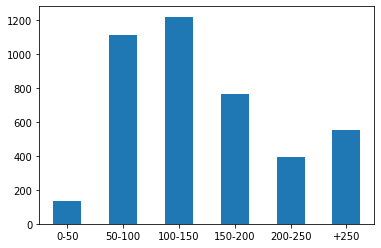

In [8]:
prices = pd.cut(train['price'],
                bins = [0, 50, 100, 150, 200, 250, train["price"].max()],
                labels=["0-50", "50-100", "100-150", "150-200", "200-250", "+250"])
 
prices.value_counts().sort_index().plot(kind="bar", rot = 0)

In [9]:
mayoria = train[train['price']<=250].shape[0]
total = train.shape[0]
mayoria/total #Casi el 87% de los precios estan por debajo de 250€

0.8682505399568035

### LOOKING @ COLUMNS

How does our df's rows look like?
Just like <code>df.head(1)</code>, but nicer ;)

In [10]:
train.sample()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
3005,3005,https://www.airbnb.com/rooms/53508687,20211205213126,2021-12-06,Luxuriously-renovated entire house in the Jordaan,*Please enquire directly for long stay discoun...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,13041485,https://www.airbnb.com/users/show/13041485,Stephen,2014-03-11,"New York, New York, United States",NaN,within a few hours,100%,0%,f,https://a0.muscache.com/im/pictures/user/5c64b...,https://a0.muscache.com/im/pictures/user/5c64b...,NaN,1,1,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,Centrum-West,NaN,52.377737,4.881552,Entire residential home,Entire home/apt,4,NaN,1.5 baths,2.0,2.0,"[""Board games"", ""Extra pillows and blankets"", ...",290.0,2,365,2.0,2.0,365.0,365.0,2.0,365.0,NaN,t,16,36,66,66,2021-12-06,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0363 16F0 1F0F 7935 80B4,f,1,1,0,0,NaN


In [11]:
#train.iloc[train['id'][0]] 

NaN values

In [12]:
nan_rank = train.isna().sum() #Most to least Nans columns
nan_rank[nan_rank.values > 0].sort_values(ascending=False)

neighbourhood_group_cleansed    4167
calendar_updated                4167
bathrooms                       4167
host_neighbourhood              1786
host_about                      1512
host_response_time              1413
host_response_rate              1413
neighbourhood                   1163
neighborhood_overview           1163
host_acceptance_rate            1092
review_scores_communication      385
review_scores_location           385
review_scores_value              385
review_scores_checkin            385
review_scores_accuracy           385
review_scores_cleanliness        385
first_review                     377
last_review                      377
reviews_per_month                377
review_scores_rating             377
bedrooms                         253
beds                             174
license                           32
host_location                     12
description                        8
bathrooms_text                     8
maximum_nights_avg_ntm             1
m

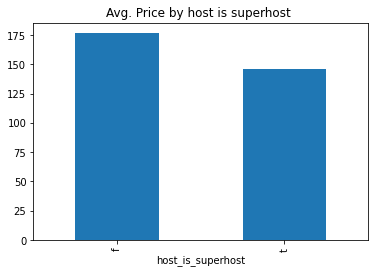

In [13]:
avg_price_superhost = train.groupby('host_is_superhost').mean()["price"]
avg_price_superhost.plot(kind="bar")
plt.title("Avg. Price by host is superhost ")
plt.show()

Al contrario de lo que podríamos esperar, el precio varía en funcion de si el host es Super o No pero
aunque de manera inversa a lo esperable

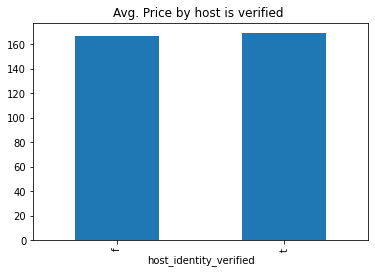

In [14]:
#plt.xticks(rotation=90)

avg_price_host_veri = train.groupby('host_identity_verified').mean()["price"]
avg_price_host_veri.plot(kind="bar")
plt.title("Avg. Price by host is verified ")
plt.show()


### ver como hacer casteo del host acceptance rate porque no me sale ni a palos

In [15]:
#train.host_acceptance_rate.astype(str)
#train.host_acceptance_rate.dtypes

#train.host_acceptance_rate = train.host_acceptance_rate.astype(str)#
#
#acc = pd.cut(train['host_acceptance_rate'],
#                bins = [0, 20, 40, 60, 80, 100],
#                labels=["0-20", "20-40", "40-60", "60-80", "80-100"])
# 
#acc.value_counts().sort_index().plot(kind="bar", rot = 0)

#avg_price_acc = train.groupby('host_acceptance_rate').mean()["price"]
#avg_price_host_veri.plot(kind="bar")
#plt.title("Avg. Price by host is verified ")
#plt.show()

In [16]:
type(train.host_acceptance_rate[0])

str

In [17]:
#CASTEO DEL HOST SINCE-->FUNCION
#train['host_since'] = train['host_since'].astype(str) #FUNCION
#train['host_since'] = pd.to_datetime(train['host_since'], format='%Y-%m-%d')

#Creo columna year_host_since
#train['host_since_year'] = pd.DatetimeIndex(train['host_since']).year
#train['host_since_year'].head()
#train = train.drop('host_since', inplace=True) # OJO QUE ESTO HAY QUE HACERLO DESPUES DE LAS TRANSFORMACIONES
#train.host_since_year.sample
#train['host_since'] = train['host_since'].astype(str)
#train['host_since'].dtypes
#train['host_since'] = pd.to_datetime(train['host_since'], format='%Y%m%d')
#train.host_since.dtype

In [18]:
selection = ['host_is_superhost',
    'host_since']

In [19]:
## host_since --> Me lo puedo cepillar o no??Es un datetime, ver como tranajarlo

## CLUSTERIZANDO LATITUDE Y LONGITUD

### CON HDBSCAN

In [20]:
0.01 / 6378

1.5678896205707118e-06

### HABLAR CON YONA PARA VER TEMA DE MANTENER LOS GRUPOS CLUSTERIZADOS ANTERIORMENTE:

In [21]:
#latitude y longitud los vamos a clusterizar con DBSCAN: --> METIDO EN UNA FUNCION
#!pip install hdbscan

hdbscan=HDBSCAN(min_cluster_size=3,min_samples=2,cluster_selection_epsilon=0.01,
                allow_single_cluster=False,prediction_data=True,leaf_size=30)
      
#help(hdbscan)
##PARAMS
#algorithm='best', alpha=1.0, approx_min_span_tree=True,
#    gen_min_span_tree=False, leaf_size=40, memory=Memory(cachedir=None),
#    metric='euclidean', min_cluster_size=5, min_samples=None, p=None

Cuales son la etiquetas de HDBSCAN??

In [22]:
#train.head()

In [23]:
#test=pd.read_csv('data/test.csv.zip') #Cargamos el test para ver como clusteriza los nuevos puntos

In [24]:
#test_points = np.column_stack((test['longitude'],test['latitude']))

In [25]:
#test_labels, strengths = hdbscan.prediction.approximate_predict(clasi, test_points)
#test_labels = clasi.approximate_predict(clasi, test_points)

In [26]:
#help(clasi)

### FUNCION LIMPIEZA:

In [27]:
patron='[0-9]+'

def bath_clean(x):
    bath_n=0
    
    try:
        bath_n=int(re.findall(patron, x)[0])
    except:
        bath_n=0
        
    return bath_n

def cats_clean(x):
    
    return str(x).replace('[', '').replace(']', '').replace("'", '').split(',')

In [28]:
train.beds.isna().sum()

174

In [29]:
def clean(df):
       
    #Casteo datetime:
    df['host_since'] = df['host_since'].astype(str) #casteo datetime
    df['host_since'] = pd.to_datetime(df['host_since'], format='%Y-%m-%d')
    
    #Creo nueva columna y dropeo la existente:                                                                
    df['host_since_year'] = pd.DatetimeIndex(df['host_since']).year 
    df['host_since_year'].head()  
    
    #Cluster latitud,longitud
    hdbscan=HDBSCAN(min_cluster_size=3,min_samples=2,cluster_selection_epsilon=0.01,
                    allow_single_cluster=False,prediction_data=True,leaf_size=30)
    
    locs = df[['longitude', 'latitude']] #Dataframe solo con latitudes y longitudes
    hdbscan.fit(locs)
    df['label_ubication']=hdbscan.fit_predict(locs)
    
    #Baños:
    df['bathroom']=df.bathrooms_text.apply(bath_clean)
    
    #Categories:
    df['cats']=df.host_verifications
    df.cats=df.cats.apply(cats_clean)
    
    df.cats=df.cats.apply(lambda x: x[0])
    df=df.reset_index(drop=True)
    df=pd.concat([df, pd.get_dummies(df.cats).reset_index(drop=True)], axis=1)
    
    #Dumies room_type:
    pd.get_dummies(df, columns = ['room_type'])
    
    #Casting beds:
    df.beds = df.beds.fillna(0)
    df.beds = df.beds.astype(int)
    
    
    #Dropeo todo lo que no quiero:
    drop=['id','host_identity_verified','neighbourhood_group_cleansed',
    'calendar_updated','bathrooms','host_neighbourhood','host_about','listing_url','scrape_id','last_scraped',
    'name','description','neighborhood_overview','picture_url','host_id','host_url','host_name',
    'host_location','host_response_time','host_response_rate','host_acceptance_rate',
    'host_is_superhost','host_since','review_scores_communication',
    'review_scores_location','review_scores_value','review_scores_checkin','review_scores_accuracy',
    'review_scores_cleanliness','first_review','last_review','reviews_per_month','latitude','longitude',
    'host_thumbnail_url','host_picture_url','host_total_listings_count','host_has_profile_pic',
    'neighbourhood','neighbourhood_cleansed','property_type','bathrooms_text','amenities',
    'minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
    'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','has_availability',
    'availability_30','availability_60','availability_90','availability_365','calendar_last_scraped',
    'number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_rating',
    'license','instant_bookable','host_verifications','bedrooms','room_type','cats']
    for i in drop:
        df = df.drop(i, axis=1)
        
    return df

In [30]:
clean(train)

,host_listings_count,accommodates,beds,price,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_since_year,label_ubication,bathroom,,email,jumio,phone,reviews
0,13,3,0,87.0,10,0,10,0,2012,0,1,0,1,0,0,0
1,0,4,2,250.0,1,1,0,0,2015,6,1,0,1,0,0,0
2,20,2,1,151.0,20,4,0,0,2018,6,1,0,1,0,0,0
3,1,2,1,139.0,1,1,0,0,2016,6,1,0,1,0,0,0
4,1,2,2,95.0,1,0,1,0,2013,6,1,0,1,0,0,0
5,2,2,1,140.0,3,0,3,0,2012,6,1,0,1,0,0,0
6,1,2,1,112.0,1,1,0,0,2016,6,1,0,1,0,0,0
7,1,2,1,119.0,1,0,1,0,2017,6,1,0,1,0,0,0
8,2,4,1,199.0,1,1,0,0,2013,6,1,0,1,0,0,0
9,8,2,1,80.0,9,0,9,0,2019,6,1,0,1,0,0,0


MIRAR BIEN LO DE CATS / QUE SOLO COGE EL PRIMER
MIRAR TB LO DE LOS AMENITIES QUE ME LOS HE CEPILLADO


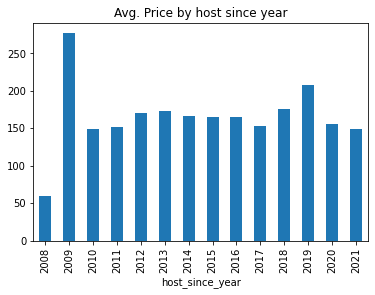

In [31]:
avg_price_host_since = train.groupby('host_since_year').mean()["price"]
avg_price_host_since.plot(kind="bar")
plt.title("Avg. Price by host since year")
plt.show()

# H2O

In [32]:
import h2o
from h2o.automl import H2OAutoML

In [33]:
h2o.init(
    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=12  # in gigabytes
)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.20.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.20.04, mixed mode, sharing)
  Starting server from /home/vp/miniconda3/envs/ironhack/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpf6i6dxz6
  JVM stdout: /tmp/tmpf6i6dxz6/h2o_vp_started_from_python.out
  JVM stderr: /tmp/tmpf6i6dxz6/h2o_vp_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,"7 days, 6 hours and 9 minutes"
H2O_cluster_name:,H2O_from_python_vp_easqbk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [34]:
trainh2o = h2o.H2OFrame(train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [35]:
x = trainh2o.columns
y = "price"
x.remove(y)

In [ ]:
aml = H2OAutoML(max_models=30, seed=15)
aml.train(x=x, y=y, training_frame=trainh2o)

AutoML progress: |
00:01:12.768: _train param, Dropping bad and constant columns: [amenities, picture_url, neighbourhood_group_cleansed, calendar_updated, listing_url, name, description, bathrooms, scrape_id]

███████
00:02:48.940: _train param, Dropping bad and constant columns: [amenities, picture_url, neighbourhood_group_cleansed, calendar_updated, listing_url, name, description, bathrooms, scrape_id]

██████████
00:03:50.15: _train param, Dropping bad and constant columns: [amenities, picture_url, neighbourhood_group_cleansed, calendar_updated, listing_url, name, description, bathrooms, scrape_id]

█
00:04:24.162: _train param, Dropping unused columns: [amenities, picture_url, neighbourhood_group_cleansed, calendar_updated, listing_url, name, description, bathrooms, scrape_id]
00:04:26.167: _train param, Dropping bad and constant columns: [amenities, picture_url, neighbourhood_group_cleansed, calendar_updated, listing_url, name, description, bathrooms, scrape_id]

████
00:05:33.282

In [ ]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)[:5]

In [ ]:
test = pd.read_csv('data/test.csv.zip')

In [ ]:
test2o = h2o.H2OFrame(test)

In [ ]:
prediccion_test_completo = aml.leader.predict(testh2o)

In [ ]:
#Nombre predicciones nuevas

In [ ]:
nombre = predicciones4

In [ ]:
test_pandas = h2o.as_list(prediccion_test_completo)
test_pandas.to_csv((f"data/{}.csv").format(nombre))
sample = pd.read_csv('data/sample.csv')
sample.price = test_pandas.predict  #Cambiamos columna price por la Series de Pandas que tenemos
sample.to_csv('data/modelo3_predict.csv', index = False)